In [1]:
import cvxopt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hwutils as util

from functools import partial
from collections import namedtuple

%matplotlib inline

In [2]:
import importlib
importlib.reload(util)

<module 'hwutils' from '/home/bogdan/Projects/cs1156x/hwutils.py'>

### Validation

In [3]:
def prepare_data(filepath):
    raw = pd.read_csv(filepath, delimiter='\s+', header=None).as_matrix()
    X = raw[:, :2]
    y = raw[:, 2]
    return X, y

In [4]:
train_data_path = './data/in.dta'
test_data_path = './data/out.dta'

X_in, y_in = prepare_data(train_data_path)
X_out, y_out = prepare_data(test_data_path)

In [5]:
def transform(X, k=7):
    assert k in range(3, 7+1), 'k should be between 3 and 7'
    
    apply = {3: lambda X: np.square(X[:, 0]),
             4: lambda X: np.square(X[:, 1]),
             5: lambda X: np.multiply(*X.T),
             6: lambda X: np.abs(X[:, 0] - X[:, 1]),
             7: lambda X: np.abs(X[:, 0] + X[:, 1])}
    
    Z = np.ones(shape=(X.shape[0], k+1))
    Z[:, 1:2+1] = X
    
    for i in range(3, k+1):
        Z[:, i] = apply[i](X)
    
    return Z

In [6]:
def highlight(series, apply, color):
    """
    Highlight a cell in pandas.Series based on the criteria specified.
    Taken from here: pandas.pydata.org/pandas-docs/stable/style.html
    """
    return ['background-color: {}'.format(color) if v else '' for v in series == apply(series)]

highlight_min = partial(highlight, apply=min, color='#ffadad')

**Problems 1-4**

In [7]:
def run_problems_1to4_solution():
    # Problem essence part
    ks_to_check = [3, 4, 5, 6, 7]

    err_values = {'val': [], 'out': []}
    for k in ks_to_check:
        Z_train = transform(X_train, k)
        Z_val = transform(X_val, k)
        Z_out = transform(X_out, k)

        w_hat = util.fit_linear_regression(X=Z_train, y=y_train)
        Eval = util.calculate_clf_error(X=Z_val, y_true=y_val, w_hat=w_hat)
        Eout = util.calculate_clf_error(X=Z_out, y_true=y_out, w_hat=w_hat)

        err_values['val'].append(Eval)
        err_values['out'].append(Eout)

    # Presentation part
    colnames = ['k', 'Validation error', 'Out-of-sample error']
    return (pd.DataFrame({colnames[0]: ks_to_check,
                   colnames[1]: err_values['val'],
                   colnames[2]: err_values['out']})
            [colnames]
            .set_index(colnames[0])
            .sort_values(by=colnames[2])
            .style.apply(highlight_min))

Problems 1, 2

In [8]:
X_train, y_train = X_in[  :25], y_in[  :25]
X_val,   y_val   = X_in[25:  ], y_in[25:  ]

run_problems_1to4_solution()

,Validation error,Out-of-sample error
k,,
7,0.1,0.072
6,0,0.084
5,0.2,0.188
4,0.5,0.416
3,0.3,0.42


Problems 3, 4

In [9]:
X_train, y_train = X_in[25:  ], y_in[25:  ]
X_val,   y_val   = X_in[  :25], y_in[  :25]

run_problems_1to4_solution()

,Validation error,Out-of-sample error
k,,
6,0.08,0.192
7,0.12,0.196
5,0.2,0.284
4,0.36,0.388
3,0.28,0.396


### Validation Bias

In [10]:
size = int(1e7)
np.random.uniform(size=(2, size)).min(axis=0).mean()

0.33333464431482385

### PLA vs. SVM

In [4]:
_SVM = namedtuple(typename='SVM', field_names='weights n_sv')

def fit_SVM(X, y):
    N = y.size

    X_has_dummy_variable = np.array_equal(X[:, 0], np.ones(N))
    Z = X[:, 1:] if X_has_dummy_variable else X 
    
    # ===== Quadratic programming part =====    
    # Solver won't give back alphas for non-support vectors exactly equaling zero.
    # For this reason we're placing a threshold below which we'll consider a value
    # being zero.
    zero_value_threshold = 1e-6
    
    quad_coefs = np.empty((N, N))
    for n in range(N):
        for m in range(N):
            quad_coefs[n, m] = y[n]*y[m]*Z[n]@Z[m]

    kwargs = {'P': quad_coefs,
              'q': -np.ones(N),
              'G': -np.identity(N),
              'h': np.zeros(N),
              'b': 0.0}
    kwargs = {k: cvxopt.matrix(v) for k, v in kwargs.items()}
    kwargs['A'] = cvxopt.matrix(y, (1, N))

    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(**kwargs)
    alpha = np.array(solution['x']).reshape(N)
    
    # ===== Getting optimal hyperplane parameters =====
    sv_idxs = np.where(alpha > zero_value_threshold)
    
    a_sv = alpha[sv_idxs]
    y_sv = y[sv_idxs]
    Z_sv = Z[sv_idxs]
    
    w = np.sum(a_sv * y_sv * Z_sv.T, axis=1)
    b = 1/y_sv[0] - w@Z_sv[0]

    return _SVM(weights=np.insert(w, 0, b),
                n_sv=a_sv.size)

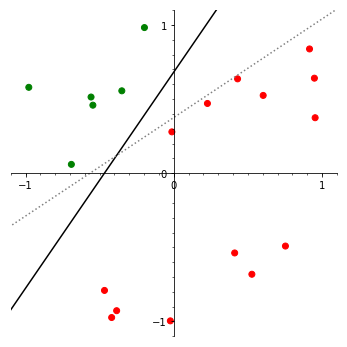

In [49]:
INTERVAL = np.array([-1., 1.])

train_size = 20

w_true = util.get_2D_line(*np.random.uniform(*INTERVAL, 4))
X, y = \
    util.get_2D_linearly_separated_datasets(interval=INTERVAL,
                                            weights=w_true,
                                            train_size=train_size)

svm = fit_SVM(X, y)
util.plot_2D_points_and_lines(X=X, y=y, lines_params=[{'weights': svm.weights, 'style': '-', 'color': 'black'},
                                                      {'weights': w_true, 'style': ':', 'color': 'gray'}])